# Introduction to Supervised Machine Learning

In [1]:
import sys
import datetime as dt

In [133]:
# Notebook Info
nb_info = {'Author':'Simon Zahn', 'Last Updated':dt.datetime.now().strftime('%Y-%m-%d %H:%M'), 'Python Version':sys.version }

for k,v in nb_info.items():
    print((k + ':').ljust(18), str(v))

Author:            Simon Zahn
Last Updated:      2019-08-12 17:06
Python Version:    3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]


--------------------------
### Table of Contents

1. [Imports and Top Matter](#Imports-and-Top-Matter)
1. [Classification](#Classification)
1. [Regression](#Regression)
1. [Fine-Tuning Your Model](#Fine-Tuning-Your-Model)
1. [Preprocessing Data](#Preprocessing-Data)
--------------------------

### Imports and Top Matter
[[back to top]](#Table-of-Contents)

In [3]:
# standard library
import itertools
import functools

# general

# IPython
from IPython.display import display, Image

# analysis
import numpy as np
import pandas as pd
from scipy import stats, special

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
# scikit-learn imports
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression, ElasticNet
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn import datasets

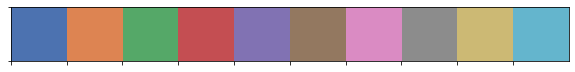

In [5]:
#print(plt.style.available)
plt.style.use('seaborn-deep')
pal = sns.color_palette(palette='deep')
sns.palplot(pal)

### Classification
[[back to top]](#Table-of-Contents)

To start, we'll be working with a dataset obtained from the UCI Machine Learning Repository consisting of votes made by US House of Representatives Congressmen. Our goal will be to predict their party affiliation ('Democrat' or 'Republican') based on how they voted on certain key issues. Here, it's worth noting that we have preprocessed this dataset to deal with missing values. This is so that our focus can be directed towards understanding how to train and evaluate supervised learning models. Once we've have mastered these fundamentals, we  will be introduced to preprocessing techniques a little later on and have the chance to apply them there ourselves on this very same dataset.

Before thinking about what supervised learning models you can apply to this, however, we need to perform Exploratory data analysis (EDA) in order to understand the structure of the data. For a refresher on the importance of EDA, refer back to 2-1 Statistical Thinking in Python.

Let's being our EDA now by exploring this voting records dataset numerically.

In [6]:
column_names = ['party', 'infants', 'water', 'budget', 'physician', 'salvador', 'religious', 'satellite', 'aid',
                'missile', 'immigration', 'synfuels', 'education', 'superfund', 'crime', 'duty_free_exports', 'eaa_rsa']

df = pd.read_csv('data\house-votes-84.csv', header=None, names=column_names)

# Convert n and y to 0 and 1
mapping={'n':0, 'y':1, '?':np.nan}
df.replace(mapping, inplace=True)

# Replace NaN values with column median
df.fillna(df.median(), inplace=True)

# Convert all values to integers
df['party'] = df['party'].astype('category')
df.iloc[:, 1:] = df.iloc[:, 1:].astype(int)

In [7]:
df.head()

party  infants  water  budget  physician  salvador  religious  \
0  republican        0      1       0          1         1          1   
1  republican        0      1       0          1         1          1   
2    democrat        0      1       1          0         1          1   
3    democrat        0      1       1          0         1          1   
4    democrat        1      1       1          0         1          1   

   satellite  aid  missile  immigration  synfuels  education  superfund  \
0          0    0        0            1         0          1          1   
1          0    0        0            0         0          1          1   
2          0    0        0            0         1          0          1   
3          0    0        0            0         1          0          1   
4          0    0        0            0         1          0          1   

   crime  duty_free_exports  eaa_rsa  
0      1                  0        1  
1      1                  0        1  
2      1                  0        0  
3      0                  0        1  
4      1                  1        1

In [8]:
df.describe()

infants       water      budget   physician    salvador   religious  \
count  435.000000  435.000000  435.000000  435.000000  435.000000  435.000000   
mean     0.429885    0.558621    0.606897    0.406897    0.521839    0.650575   
std      0.495630    0.497123    0.489002    0.491821    0.500098    0.477337   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    1.000000    1.000000    0.000000    1.000000    1.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

        satellite         aid     missile  immigration    synfuels  \
count  435.000000  435.000000  435.000000   435.000000  435.000000   
mean     0.581609    0.590805    0.526437     0.512644    0.344828   
std      0.493863    0.492252    0.499876     0.500416    0.475859   
min      0.000000    0.000000    0.000000     0.000000    0.000000   
25%      0.000000    0.000000    0.000000     0.000000    0.000000   
50%      1.000000    1.000000    1.000000     1.000000    0.000000   
75%      1.000000    1.000000    1.000000     1.000000    1.000000   
max      1.000000    1.000000    1.000000     1.000000    1.000000   

        education   superfund       crime  duty_free_exports     eaa_rsa  
count  435.000000  435.000000  435.000000         435.000000  435.000000  
mean     0.393103    0.537931    0.609195           0.400000    0.857471  
std      0.489002    0.499133    0.488493           0.490462    0.349994  
min      0.000000    0.000000    0.000000           0.000000    0.000000  
25%      0.000000    0.000000    0.000000           0.000000    1.000000  
50%      0.000000    1.000000    1.000000           0.000000    1.000000  
75%      1.000000    1.000000    1.000000           1.000000    1.000000  
max      1.000000    1.000000    1.000000           1.000000    1.000000

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
party                435 non-null category
infants              435 non-null int32
water                435 non-null int32
budget               435 non-null int32
physician            435 non-null int32
salvador             435 non-null int32
religious            435 non-null int32
satellite            435 non-null int32
aid                  435 non-null int32
missile              435 non-null int32
immigration          435 non-null int32
synfuels             435 non-null int32
education            435 non-null int32
superfund            435 non-null int32
crime                435 non-null int32
duty_free_exports    435 non-null int32
eaa_rsa              435 non-null int32
dtypes: category(1), int32(16)
memory usage: 27.8 KB


The Numerical EDA gave us some very important information, such as the names and data types of the columns, and the dimensions of the DataFrame. Following this with some visual EDA will give us an even better understanding of the data. Since all the features in this dataset are binary; we can do a simple `countplot` to help visualize this data.

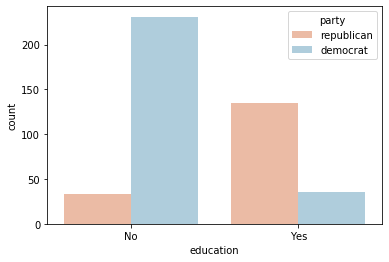

In [10]:
plt.figure()
sns.countplot(x='education', hue='party', data=df, hue_order=['republican', 'democrat'], palette='RdBu')
plt.xticks([0,1], ['No', 'Yes']);

In `sns.countplot()`, we specify the x-axis data to be 'education', and hue to be 'party'. Recall that 'party' is also our target variable. So the resulting plot shows the difference in voting behavior between the two parties for the 'education' bill, with each party colored differently. We manually specified the color to be 'RdBu', as the Republican party has been traditionally associated with red, and the Democratic party with blue.

It seems like Democrats voted resoundingly against this bill, compared to Republicans. This is the kind of information that our machine learning model will seek to learn when we try to predict party affiliation solely based on voting behavior. An expert in U.S politics may be able to predict this without machine learning, but probably not instantaneously - and certainly not if we are dealing with hundreds of samples!

Having explored the Congressional voting records dataset, it is time now to build our first classifier. We will fit a k-Nearest Neighbors classifier to the voting dataset. The features of the dataset need to be in an array where each column is a feature and each row a different observation or data point - in this case, a Congressman's voting record. The target needs to be a single column with the same number of observations as the feature data. Notice we named the feature array X and response variable y: This is in accordance with the common scikit-learn practice.

Once we fit a k-NN classifier, we can now use it to predict the label of a new data point. However, there is no unlabeled data available since all of it was used to fit the model! You can still use the .predict() method on the X that was used to fit the model, but it is not a good indicator of the model's ability to generalize to new, unseen data.

For now, let's make a random unlabeled data point called `X_new`. We will use your classifier to predict the label for this new data point, as well as on the training data `X` that the model has already seen. Using `.predict()` on `X_new` will generate 1 prediction, while using it on `X` will generate 435 predictions: 1 for each sample.

In [11]:
# Create X_new for testing
X_new = np.array([0.696469, 0.286139, 0.226851, 0.551315, 0.719469, 0.423106, 0.980764, 0.68483,
                  0.480932, 0.392118, 0.343178, 0.72905, 0.438572, 0.059678, 0.398044, 0.737995])
print(X_new.shape)

# use reshape to specify that this is an sample (row)
X_new = X_new.reshape(1, -1)  
print(X_new.shape)

(16,)
(1, 16)


In [12]:
# Create arrays for the features and the response variable
y = df['party'].values
X = df.drop('party', axis=1).values

# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X, y)

# Predict the labels for the training data X
y_pred = knn.predict(X)

# Predict and print the label for the new data point X_new
new_prediction = knn.predict(X_new)
print("Prediction: {}".format(new_prediction))

Prediction: ['democrat']


Up until now, we have been performing binary classification, since the target variable had two possible outcomes. Now, we'll try our hand at multi-class classification, where the target variable could take on three possible outcomes. We'll be working with the MNIST digits recognition dataset, which has 10 classes, the digits 0 through 9. A reduced version of the MNIST dataset is one of scikit-learn's included datasets, and that is the one we will use here.

Each sample in this scikit-learn dataset is an 8x8 image representing a handwritten digit. Each pixel is represented by an integer in the range 0 to 16, indicating varying levels of black. Recall that scikit-learn's built-in datasets are of type Bunch, which are dictionary-like objects. Helpfully for the MNIST dataset, scikit-learn provides an 'images' key in addition to the 'data' and 'target' keys. Because it is a 2D array of the images corresponding to each sample, this 'images' key is useful for visualizing the images, as we'll see. On the other hand, the 'data' key contains the feature array - that is, the images as a flattened array of 64 pixels.

Notice that you can access the keys of these Bunch objects in two different ways: By using the `.` notation, as in `digits.images`, or the `[]` notation, as in `digits['images']`.

In [13]:
# Load the digits dataset: digits
digits = datasets.load_digits()

In [14]:
# print the dataset keys
print(digits.keys())

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [15]:
# print the dataset description
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [16]:
# Print the shape of the images and data keys
print(digits.images.shape)
print(digits.data.shape)

(1797, 8, 8)
(1797, 64)


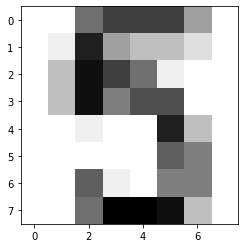

In [17]:
# Display digit 1010
plt.imshow(digits.images[1010], cmap=plt.cm.gray_r, interpolation='nearest')

Now we have to split the data into training and test sets. After creating arrays for the features and target variable, we will split them into training and test sets, fit a k-NN classifier to the training data, and then compute its accuracy using the `.score()` method.

In [18]:
# Create feature and target arrays
X = digits.data
y = digits.target

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

# Create a k-NN classifier with 7 neighbors: knn
knn = KNeighborsClassifier(n_neighbors=7)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Print the accuracy
print(knn.score(X_test, y_test))

0.9833333333333333


Incredibly, this out of the box k-NN classifier with 7 neighbors has learned from the training data and predicted the labels of the images in the test set with 98% accuracy, and it did so in less than a second! This is one illustration of how incredibly useful machine learning techniques can be.

We can now construct a model complexity curve digits dataset. We'll compute and plot the training and testing accuracy scores for a variety of different neighbor values. By observing how the accuracy scores differ for the training and testing sets with different values of k, we can develop our intuition for overfitting and underfitting.

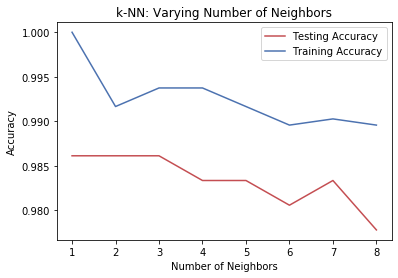

In [19]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.plot(neighbors, test_accuracy, color=pal[3], label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, color=pal[0], label='Training Accuracy')
plt.title('k-NN: Varying Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.legend();

### Regression
[[back to top]](#Table-of-Contents)

In this chapter, we'll work with Gapminder data that we have consolidated into one CSV file available in the workspace as 'gapminder.csv'. Specifically, our goal will be to use this data to predict the life expectancy in a given country based on features such as the country's GDP, fertility rate, and population. Since the target variable here is quantitative, this is a regression problem. To begin, we will fit a linear regression with just one feature: 'fertility', which is the average number of children a woman in a given country gives birth to.

Before that, however, we need to import the data and get it into the form needed by scikit-learn. This involves creating feature and target variable arrays. Furthermore, since we are going to use only one feature to begin with, we need to do some reshaping using NumPy's `.reshape()` method. Don't worry too much about this reshaping right now, but it is something we will have to do occasionally when working with scikit-learn so it is useful to practice.

In [20]:
# Read the CSV file into a DataFrame: df
df = pd.read_csv('data/gm_2008_region.csv')

In [21]:
# Create arrays for features and target variable
y = df.life.values
X = df.fertility.values

# Print the dimensions of X and y before reshaping
print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(X.shape))

# Reshape X and y
y = y.reshape(-1, 1)
X = X.reshape(-1, 1)

# Print the dimensions of X and y after reshaping
print("Dimensions of y after reshaping: {}".format(y.shape))
print("Dimensions of X after reshaping: {}".format(X.shape))

Dimensions of y before reshaping: (139,)
Dimensions of X before reshaping: (139,)
Dimensions of y after reshaping: (139, 1)
Dimensions of X after reshaping: (139, 1)


As always, it is important to explore the data before building models. Below, we can construct a heatmap showing the correlation between the different features of the Gapminder dataset. Take a moment to explore this: Which features are positively correlated with life, and which ones are negatively correlated? Does this match your intuition?

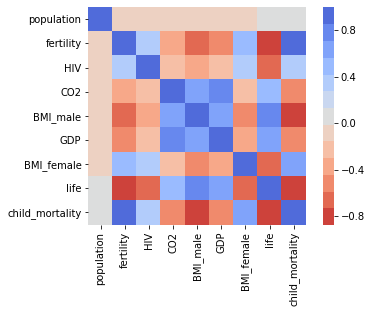

In [22]:
sns.heatmap(df.corr(), square=True, cmap=sns.color_palette("coolwarm_r", 13));

Now, we will fit a linear regression and predict life expectancy using just one feature. We will use the 'fertility' feature of the Gapminder dataset. Since the goal is to predict life expectancy, the target variable here is 'life'.

First, we generate scatter plot with 'fertility' on the x-axis and 'life' on the y-axis. As we can see, there is a strongly negative correlation, so a linear regression should be able to capture this trend. Our goal is to fit a linear regression and then predict the life expectancy, overlaying these predicted values on the plot to generate a regression line.

In [23]:
df.head()

population  fertility  HIV        CO2  BMI_male      GDP  BMI_female  life  \
0  34811059.0       2.73  0.1   3.328945  24.59620  12314.0    129.9049  75.3   
1  19842251.0       6.43  2.0   1.474353  22.25083   7103.0    130.1247  58.3   
2  40381860.0       2.24  0.5   4.785170  27.50170  14646.0    118.8915  75.5   
3   2975029.0       1.40  0.1   1.804106  25.35542   7383.0    132.8108  72.5   
4  21370348.0       1.96  0.1  18.016313  27.56373  41312.0    117.3755  81.5   

   child_mortality                      Region  
0             29.5  Middle East & North Africa  
1            192.0          Sub-Saharan Africa  
2             15.4                     America  
3             20.0       Europe & Central Asia  
4              5.2         East Asia & Pacific

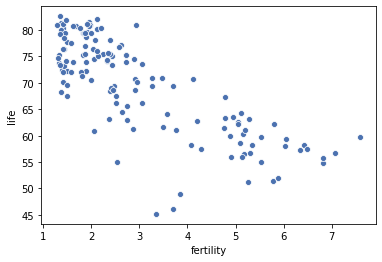

In [24]:
sns.scatterplot(x='fertility', y='life', data=df);

In [25]:
X_fertility = df.fertility.values.reshape(-1, 1)
y_fertility = df.life.values.reshape(-1, 1)

0.6192442167740035


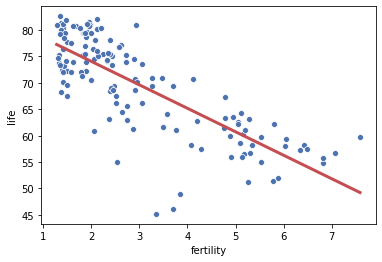

In [26]:
# Create the regressor: reg
reg = LinearRegression()

# Fit the model to the data
reg.fit(X_fertility, y_fertility)

# Create the prediction space and compute predictions over the prediction space
prediction_space = np.linspace(min(X_fertility), max(X_fertility)).reshape(-1,1)
y_pred = reg.predict(prediction_space)

# Print R^2 
print(reg.score(X_fertility, y_fertility))

# Plot regression line
sns.scatterplot(x='fertility', y='life', data=df)
plt.plot(prediction_space, y_pred, color=pal[3], linewidth=3);

Train and test sets are vital to ensure that your supervised learning model is able to generalize well to new data. This was true for classification models, and is equally true for linear regression models. Now, we'll split the Gapminder dataset into training and testing sets, and then fit and predict a linear regression over all features. In addition to computing the $R^2$ score, we will also compute the Root Mean Squared Error (RMSE), which is another commonly used metric to evaluate regression models.

In [27]:
df.head()

population  fertility  HIV        CO2  BMI_male      GDP  BMI_female  life  \
0  34811059.0       2.73  0.1   3.328945  24.59620  12314.0    129.9049  75.3   
1  19842251.0       6.43  2.0   1.474353  22.25083   7103.0    130.1247  58.3   
2  40381860.0       2.24  0.5   4.785170  27.50170  14646.0    118.8915  75.5   
3   2975029.0       1.40  0.1   1.804106  25.35542   7383.0    132.8108  72.5   
4  21370348.0       1.96  0.1  18.016313  27.56373  41312.0    117.3755  81.5   

   child_mortality                      Region  
0             29.5  Middle East & North Africa  
1            192.0          Sub-Saharan Africa  
2             15.4                     America  
3             20.0       Europe & Central Asia  
4              5.2         East Asia & Pacific

In [28]:
y = df['life'].values
X = df.drop(['life', 'Region'], axis=1).values

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.8380468731430135
Root Mean Squared Error: 3.2476010800369455


Excellent! Using all features has improved the model score. This makes sense, as the model has more information to learn from. However, there is one potential pitfall to this process. Can you spot it?

Cross-validation is a vital step in evaluating a model. It maximizes the amount of data that is used to train the model, as during the course of training, the model is not only trained, but also tested on all of the available data. $k$-fold CV splits the data into $k$ groups, or folds. We train on $k-1$ folds, and test on the left out fold. We loop through so each fold is left out once to be the test set. This means that we get $k$ CV values. By default, scikit-learn's `cross_val_score()` function uses $R^2$ as the metric of choice for regression.

Here, we will practice 5-fold cross validation on the Gapminder data.  Since we are performing 5-fold cross-validation, the function will return 5 scores. Our job is to compute these 5 scores and then take their average.

In [29]:
# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X, y, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.81720569 0.82917058 0.90214134 0.80633989 0.94495637]
Average 5-Fold CV Score: 0.8599627722793451


Cross validation is essential but do not forget that the more folds you use, the more computationally expensive cross-validation becomes. 

In [30]:
# Create a linear regression object: reg
reg = LinearRegression()

# Perform 3-fold CV
print('3-fold CV')
%timeit cross_val_score(reg, X, y, cv=3)
cvscores_3 = cross_val_score(reg, X, y, cv=3)
print('Mean R^2 Score: ', np.mean(cvscores_3))
print()

# Perform 10-fold CV
print('10-fold CV')
%timeit cross_val_score(reg, X, y, cv=10)
cvscores_10 = cross_val_score(reg, X, y, cv=10)
print('Mean R^2 Score: ', np.mean(cvscores_10))

3-fold CV
6.69 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Mean R^2 Score:  0.8718712782622262

10-fold CV
14.1 ms ± 746 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Mean R^2 Score:  0.8436128620131266


Now, we will fit a lasso regression to the Gapminder data we have been working with and plot the coefficients. We'll see that the coefficients of some features are shrunk to 0, with only the most important ones remaining.

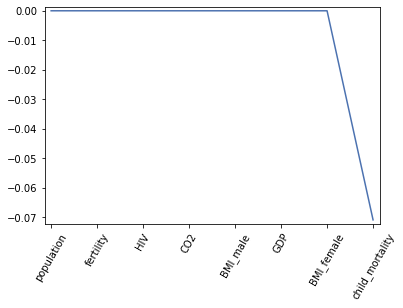

In [31]:
y = df['life'].values
X = df.drop(['life', 'Region'], axis=1).values

# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.4, normalize=True)

# Fit the regressor to the data
lasso.fit(X, y)

# Plot the Lasso coefficients
plt.plot(range(X.shape[1]), lasso.coef_)
plt.xticks(range(X.shape[1]), df.drop(['life', 'Region'], axis=1).columns.values, rotation=60)
plt.margins(0.02)

Great work! According to the lasso algorithm, it seems like `'child_mortality'` is the most important feature when predicting life expectancy.

Lasso is great for feature selection, but when building regression models, Ridge regression should typicall be your first choice.

Recall that lasso performs regularization by adding to the loss function a penalty term of the absolute value of each coefficient multiplied by some alpha. This is also known as L1 regularization because the regularization term is the L1 norm of the coefficients. This is not the only way to regularize, however.

If instead you took the sum of the squared values of the coefficients multiplied by some alpha - like in Ridge regression - you would be computing the L2 norm. Here, we will practice fitting ridge regression models over a range of different alphas, and plot cross-validated $R^2$ scores for each.

In [32]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')

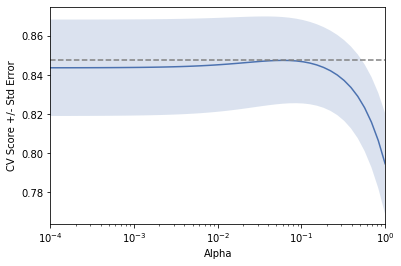

In [33]:
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

Great work! Notice how the cross-validation scores change with different alphas. Which alpha should we pick? How can you fine-tune your model? Let's dive into that now!

### Fine-Tuning Your Model
[[back to top]](#Table-of-Contents)

First, we evaluated the performance of our k-NN classifier based on its accuracy. However, accuracy is not always an informative metric. Now, we will dive more deeply into evaluating the performance of binary classifiers by computing a confusion matrix and generating a classification report.

A classification report consisted of multiple rows, and an additional support column. The support gives the number of samples of the true response that lie in that class. The precision, recall, and f1-score columns gave the respective metrics for that particular class.

Here, we'll work with the PIMA Indians dataset obtained from the UCI Machine Learning Repository. The goal is to predict whether or not a given female patient will contract diabetes based on features such as BMI, age, and number of pregnancies. Therefore, it is a binary classification problem. A target value of 0 indicates that the patient does not have diabetes, while a value of 1 indicates that the patient does have diabetes.

We start by training a k-NN classifier to the data and evaluate its performance by generating a confusion matrix and classification report, then we take a similar approach using logistic regression, and add in an ROC curve.

In [34]:
pima_df = pd.read_csv('data/diabetes.csv')

In [35]:
y = pima_df['diabetes'].values
X = pima_df.drop(['diabetes'], axis=1).values

In [36]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Instantiate a k-NN classifier: knn
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = knn.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

[[176  30]
 [ 56  46]]

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       206
           1       0.61      0.45      0.52       102

    accuracy                           0.72       308
   macro avg       0.68      0.65      0.66       308
weighted avg       0.71      0.72      0.71       308



In [37]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

# Create the classifier: logreg
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)  # for sklearn 0.22 compatibility

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

[[168  38]
 [ 36  66]]

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       206
           1       0.63      0.65      0.64       102

    accuracy                           0.76       308
   macro avg       0.73      0.73      0.73       308
weighted avg       0.76      0.76      0.76       308



Classification reports and confusion matrices are great methods to quantitatively evaluate model performance, while ROC curves provide a way to visually evaluate models. Most classifiers in scikit-learn have a `.predict_proba()` method which returns the probability of a given sample being in a particular class. Having built a logistic regression model, we'll now evaluate its performance by plotting an ROC curve. In doing so, we'll make use of the `.predict_proba()` method and become familiar with its functionality.

Using the `logreg` classifirer above...

AUC: 0.8243384732533791
AUC scores computed using 5-fold cross-validation: [0.81240741 0.80777778 0.82555556 0.87283019 0.84490566]


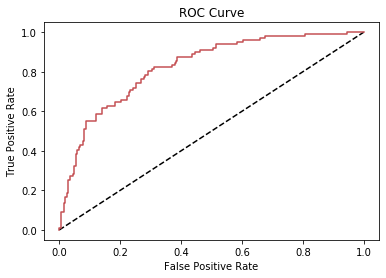

In [38]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg, X, y, scoring='roc_auc', cv=5)

# Print list of ROC and AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, color=pal[3])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve');

##### Hyperparameter Tuning

Like the alpha parameter of lasso and ridge regularization that we saw earlier, logistic regression also has a regularization parameter: C. C controls the inverse of the regularization strength; a large C can lead to an overfit model, while a small C can lead to an underfit model.

We will use `GridSearchCV` and logistic regression to find the optimal C in this hyperparameter space. You may be wondering why you aren't asked to split the data into training and test sets. Good observation! Here, we want you to focus on the process of setting up the hyperparameter grid and performing grid-search cross-validation.

In [46]:
# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='lbfgs', max_iter=500)  # for sklearn 0.22 compatibility

# Setup the hyperparameter grid and instantiate the GridSearchCV object: logreg_cv
param_grid = {'C':np.logspace(-5, 8, 15)}
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.006105402296585327}
Best score is 0.7734375


`GridSearchCV` can be computationally expensive, especially if you are searching over a large hyperparameter space and dealing with multiple hyperparameters. A solution to this is to use `RandomizedSearchCV`, in which not all hyperparameter values are tried out. Instead, a fixed number of hyperparameter settings is sampled from specified probability distributions. We'll practice using `RandomizedSearchCV` in this exercise and see how this works.

Here, we'll also be introduced to a new model: the Decision Tree. Don't worry about the specifics of how this model works. Just like k-NN, linear regression, and logistic regression, decision trees in scikit-learn have `.fit()` and `.predict()` methods that you can use in exactly the same way as before. Decision trees have many parameters that can be tuned, such as `max_features`, `max_depth`, and `min_samples_leaf`: This makes it an ideal use case for `RandomizedSearchCV`.

In [47]:
# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Setup the parameters and distributions to sample from: param_dist and instantiate the RandomizedSearchCV object
param_dist = {"max_depth": [3, None],
              "max_features": stats.randint(1, 9),
              "min_samples_leaf": stats.randint(1, 9),
              "criterion": ["gini", "entropy"]}
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 1}
Best score is 0.7408854166666666


We will now practice evaluating a model with tuned hyperparameters on a hold-out set. In addition to C, logistic regression has a 'penalty' hyperparameter which specifies whether to use 'l1' or 'l2' regularization. We want to create a hold-out set, and tune the 'C' and 'penalty' hyperparameters of a logistic regression classifier using GridSearchCV on the training set.

In [64]:
# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression(solver='liblinear', max_iter=100)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, iid=False)

# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy from CV: {}".format(logreg_cv.best_score_))


# Predict on the test set and compute metrics
y_pred = logreg_cv.predict(X_test)
print()
print('Confusion Matrix on Hold Out Set')
print(confusion_matrix(y_test, y_pred))
print()
print('Classification Report on Hold Out Set')
print(classification_report(y_test, y_pred))

Tuned Logistic Regression Parameter: {'C': 31.622776601683793, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy from CV: 0.7673337648793469

Confusion Matrix on Hold Out Set
[[167  39]
 [ 36  66]]

Classification Report on Hold Out Set
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       206
           1       0.63      0.65      0.64       102

    accuracy                           0.76       308
   macro avg       0.73      0.73      0.73       308
weighted avg       0.76      0.76      0.76       308



In [60]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Instantiate the Ridge regressor
ridge = Ridge()

# Create the hyperparameter grid and setup the GridSearchCV object
param_grid = {'alpha': np.linspace(0, 10000, 500)}
ridge_cv = GridSearchCV(ridge, param_grid, iid=False, cv=5)

# Fit it to the training data
ridge_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = ridge_cv.predict(X_test)
r2 = ridge_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned Ridge alpha: {}".format(ridge_cv.best_params_))
print("Tuned Ridge R squared: {}".format(r2))
print("Tuned Ridge MSE: {}".format(mse))

Tuned Ridge alpha: {'alpha': 1983.9679358717435}
Tuned Ridge R squared: 0.2468312784982585
Tuned Ridge MSE: 0.16682388657651578


### Preprocessing Data
[[back to top]](#Table-of-Contents)

The Gapminder dataset that we worked with in previous chapters also contained a categorical 'Region' feature, which we dropped in previous exercises since we did not have the tools to deal with it. Now however, we do, so let's it back in!

In [65]:
# Read the CSV file into a DataFrame: df
df = pd.read_csv('data/gm_2008_region.csv')

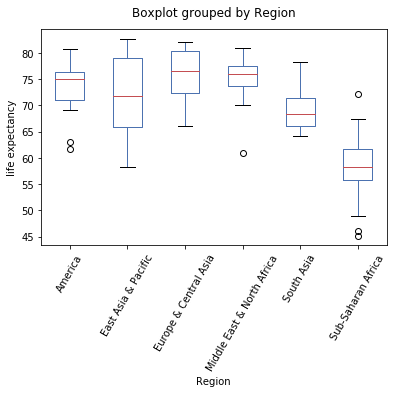

In [79]:
# Create a boxplot of life expectancy per region
df.boxplot('life', 'Region', grid=False, rot=60)
plt.title('') # remove auto-title which overlaps with sup title
plt.ylabel('life expectancy');

Scikit-learn does not accept non-numerical features. We can see that the 'Region' feature contains very useful information that can predict life expectancy. For example, Sub-Saharan Africa has a lower life expectancy compared to Europe and Central Asia. Therefore, if we are trying to predict life expectancy, it would be preferable to retain the 'Region' feature. To do this, we need to binarize it by creating dummy variables.

When we create dummies, sometimes we want to drop one of the columns. For example, if we have marbles that are either blue, red, or gree, then we really only need two color columns, because if both are 0 the marble is the 3rd color by default. Furthermore, in some models, having the duplicate information can negatively impact the model, so it's preferable to remove it.

In [81]:
# Create dummy variables
df_region = pd.get_dummies(df)

# Print the columns of df_region
print(df_region.columns)

# Create dummy variables with drop_first=True to remove duplicate information
df_region = pd.get_dummies(df, drop_first=True)

# Print the new columns of df_region
print(df_region.columns)

Index(['population', 'fertility', 'HIV', 'CO2', 'BMI_male', 'GDP',
       'BMI_female', 'life', 'child_mortality', 'Region_America',
       'Region_East Asia & Pacific', 'Region_Europe & Central Asia',
       'Region_Middle East & North Africa', 'Region_South Asia',
       'Region_Sub-Saharan Africa'],
      dtype='object')
Index(['population', 'fertility', 'HIV', 'CO2', 'BMI_male', 'GDP',
       'BMI_female', 'life', 'child_mortality', 'Region_East Asia & Pacific',
       'Region_Europe & Central Asia', 'Region_Middle East & North Africa',
       'Region_South Asia', 'Region_Sub-Saharan Africa'],
      dtype='object')


In [82]:
y = df_region['life'].values
X = df_region.drop('life', axis=1).values

# Instantiate a ridge regressor: ridge
ridge = Ridge(alpha=0.5, normalize=True)

# Perform 5-fold cross-validation: ridge_cv
ridge_cv = cross_val_score(ridge, X, y, cv=5)

# Print the cross-validated scores
print(ridge_cv)

[0.86808336 0.80623545 0.84004203 0.7754344  0.87503712]


The voting dataset from the beginning of this notebook contained a bunch of missing values. You will see that there are certain data points labeled with a '?'. These denote missing values. We use NaN because it is an efficient and simplified way of internally representing missing data, and it lets us take advantage of pandas methods such as `.dropna()` and `.fillna()`, as well as scikit-learn's Imputation transformer `Imputer()`.

The first thing we neeed to do is to convert the '?'s to NaNs, and then drop the rows that contain them from the DataFrame.

In [98]:
column_names = ['party', 'infants', 'water', 'budget', 'physician', 'salvador', 'religious', 'satellite', 'aid',
                'missile', 'immigration', 'synfuels', 'education', 'superfund', 'crime', 'duty_free_exports', 'eaa_rsa']

df = pd.read_csv('data\house-votes-84.csv', header=None, names=column_names)

In [99]:
# Print shape of original DataFrame
print("Shape of Original DataFrame: {}".format(df.shape))

# Print shape of new DataFrame
print("Shape of DataFrame After Dropping All Rows with Missing Values: {}".format(df.dropna().shape))

Shape of Original DataFrame: (435, 17)
Shape of DataFrame After Dropping All Rows with Missing Values: (435, 17)


In [101]:
# Convert n and y to 0 and 1
mapping={'n':0, 'y':1, '?':np.nan}
df.replace(mapping, inplace=True)

When many values in our dataset are missing, if we drop them, we may end up throwing away valuable information along with the missing data. It's better instead to develop an imputation strategy. This is where domain knowledge is useful, but in the absence of it, we can impute missing values with the mean or the median of the row or column that the missing value is in.

As we've seen, there are multiple steps to building a model, from creating training and test sets, to fitting a classifier or regressor, to tuning its parameters, to evaluating its performance on new data. Imputation can be seen as the first step of this machine learning process, the entirety of which can be viewed within the context of a pipeline. Scikit-learn provides a pipeline constructor that allows us to piece together these steps into one process and thereby simplify our workflow. What makes pipelines so incredibly useful is the simple interface that they provide. We can use the `.fit()` and `.predict()` methods on pipelines just as we did with our classifiers and regressors!

Let's do this ourselves and generate a classification report of our predictions.

In [108]:
# Create arrays for the features and the response variable
y = df['party'].values
X = df.drop('party', axis=1).values

# Create the pipeline: pipeline
pipeline = Pipeline([('imputation', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('SVM', SVC(gamma='scale'))  # for sklearn 0.22 compatibility
                    ])

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline to the train set
pipeline.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = pipeline.predict(X_test)

# Compute metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    democrat       0.98      0.96      0.97        85
  republican       0.94      0.96      0.95        46

    accuracy                           0.96       131
   macro avg       0.96      0.96      0.96       131
weighted avg       0.96      0.96      0.96       131



##### Scaling and Centering
We will now explore scaling on the PIMA dataset. Many models use some form of distance to make predictions, so having variables at widely different scales can have a detrimental effect on models.

With regard to whether or not scaling is effective, the proof is in the pudding! Let's check whether or not scaling the features has any impact on model performance. We will use a k-NN classifier as part of a pipeline that includes scaling.

In [111]:
pima_df.head()

pregnancies  glucose  diastolic  triceps  insulin   bmi    dpf  age  \
0            6      148         72       35        0  33.6  0.627   50   
1            1       85         66       29        0  26.6  0.351   31   
2            8      183         64        0        0  23.3  0.672   32   
3            1       89         66       23       94  28.1  0.167   21   
4            0      137         40       35      168  43.1  2.288   33   

   diabetes  
0         1  
1         0  
2         1  
3         0  
4         1

In [113]:
# Create arrays for the features and the response variable
y = pima_df['diabetes'].values
X = pima_df.drop(['diabetes'], axis=1).values

# Create the pipeline
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsClassifier())
                    ])

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
knn_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
knn_unscaled = KNeighborsClassifier().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(knn_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(knn_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.7012987012987013
Accuracy without Scaling: 0.6883116883116883


It is time now to piece together everything we have learned so far into a pipeline for regression! We're going to build a pipeline that includes scaling and hyperparameter tuning.

We now return to the Gapminder dataset. Guess what? Even this dataset has missing values. Now, we have all the tools to take care of them. Our job is to build a pipeline that imputes the missing data, scales the features, and fits an `SVR()` (support vector regression) to the Gapminder data. The hyperparameters for `SVR()` we will tune are `C` and `epsilon`. `C` controls the regularization strength. It is analogous to the `C` we tuned for logistic regression. We will then tune the parameters of our `SVC()` regressor using `GridSearchCV`.

We specify the hyperparameter space using the following notation: `'step_name__parameter_name'`. Here, the step_name is `SVM`, and the parameter_names are `C` and `gamma`.

In [130]:
# Read the CSV file into a DataFrame: df
df = pd.read_csv('data/gm_2008_region.csv')

In [132]:
# Create dummy variables
df_region = pd.get_dummies(df, drop_first=True)

# Create arrays for the features and the response variable
y = df_region['life'].values
X = df_region.drop('life', axis=1).values

# Setup the pipeline steps
steps = [('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),
         ('scaler', StandardScaler()),
         ('svr', SVR())]

# Create the pipeline
pipeline = Pipeline(steps)

# Specify the hyperparameter space
params = {'svr__C':np.linspace(0.1,1000,100),
          'svr__epsilon':np.linspace(0,1,50)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(pipeline, param_grid=params, iid=False, cv=5)

# Fit to the training set
gm_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = gm_cv.score(X_test, y_test)
print("Tuned SVR Parameters: {}".format(gm_cv.best_params_))
print("Tuned SVR R squared: {}".format(r2))

Tuned SVR Parameters: {'svr__C': 30.4, 'svr__epsilon': 1.0}
Tuned SVR R squared: 0.8322897593191437
